# Biebrza Pixel Time-Series Classification with PyTorch

This notebook loads the exported **biannual pixel time-series** dataset from Google Drive
and trains two neural models to classify vegetation trajectory categories:

- A **1D Convolutional Network** (Conv1D)
- An **LSTM**

It then compares their performance.

Assumptions:
- This notebook loads a table from Google Earth Engine named
  `biebrza_biannual_pixel_series.csv` from the folder `GEE_Biebrza` in Drive.
- Each row is one pixel, with columns:
  - `NDMI_YYYY_YYYY`, `NBR_YYYY_YYYY`, `NIR_YYYY_YYYY` for multiple 2-year windows
  - `traj_simpl` (original category label)
  - `numark` (square id)
  - `pixel_id` (unique pixel id)
  - `cat_id` (original numeric label, can be ignored here)


In [1]:
!pip install -q torch torchvision torchaudio scikit-learn

import os
import numpy as np
import pandas as pd
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.utils import shuffle as sk_shuffle
from sklearn.preprocessing import LabelEncoder


## Load dataset from Google Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your exported CSV (adjust if needed)
data_path = '/content/drive/MyDrive/GEE_Biebrza/biebrza_biannual_pixel_series_6_bands.csv'

df = pd.read_csv(data_path)
print('Data shape:', df.shape)
print('Columns:', df.columns.tolist()[:20], '...')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (142327, 66)
Columns: ['system:index', 'NBR_1997_1998', 'NBR_1999_2000', 'NBR_2001_2002', 'NBR_2003_2004', 'NBR_2005_2006', 'NBR_2007_2008', 'NBR_2009_2010', 'NBR_2011_2012', 'NBR_2013_2014', 'NBR_2015_2016', 'NDMI_1997_1998', 'NDMI_1999_2000', 'NDMI_2001_2002', 'NDMI_2003_2004', 'NDMI_2005_2006', 'NDMI_2007_2008', 'NDMI_2009_2010', 'NDMI_2011_2012', 'NDMI_2013_2014'] ...


Quick look at the main label columns and one row:


In [43]:
print(df[['traj_simpl', 'numark']].head())
print('\nUnique traj_simpl values:', df['traj_simpl'].unique())
print('\nNumber of unique numark values (squares from Kopeć and Sławik (2020)):', len(df['numark'].unique()))


      traj_simpl numark
0  stable_shrubs    P84
1  stable_shrubs    P84
2  stable_shrubs    P84
3  stable_shrubs    P84
4  stable_shrubs    P84

Unique traj_simpl values: ['stable_shrubs' 'stable_trees' 'stable_wetland' 'wetland_to_shrubs'
 'shrubs_to_trees' 'wetland_to_trees']

Number of unique numark values (squares from Kopeć and Sławik (2020)): 13855


## Re-label categories and prepare data (no subsampling)

Steps:
1. Merge `wetland_to_trees` into `wetland_to_shrubs` → new class `wetland_to_woody`.
2. Keep only these classes (using **all pixels**):
   - `wetland_to_woody`
   - `shrubs_to_trees`
   - `stable_wetland`
   - `stable_trees`
   - `stable_shrubs`
3. Drop all other categories.
4. Compute **class weights** based on the full filtered dataset
   (since no subsampling is performed).
5. Shuffle dataset for training.

In [44]:
import numpy as np
import pandas as pd
import torch
from sklearn.utils import shuffle as sk_shuffle

# -------------------------------------------------
# 1. Re-label categories
# -------------------------------------------------

df['class_str'] = df['traj_simpl']

# Merge wetland_to_shrubs + wetland_to_trees → wetland_to_woody
df.loc[df['class_str'].isin(['wetland_to_shrubs', 'wetland_to_trees']),
       'class_str'] = 'wetland_to_woody'

# -------------------------------------------------
# 2. Keep only desired classes (keep ALL pixels)
# -------------------------------------------------

target_classes = [
    'wetland_to_woody',
    'shrubs_to_trees',
    'stable_wetland',
    'stable_trees',
    'stable_shrubs',
]

df = df[df['class_str'].isin(target_classes)].copy()

print("After filtering, shape:", df.shape)
print("Class counts (full dataset):")
print(df['class_str'].value_counts())

# -------------------------------------------------
# 3. Shuffle final dataset
# -------------------------------------------------

df_all = sk_shuffle(df, random_state=42).reset_index(drop=True)

print("\nFinal per-class counts (after shuffle):")
print(df_all['class_str'].value_counts())

After filtering, shape: (142327, 67)
Class counts (full dataset):
class_str
stable_wetland      71229
stable_trees        45845
stable_shrubs       18990
shrubs_to_trees      4584
wetland_to_woody     1679
Name: count, dtype: int64

Final per-class counts (after shuffle):
class_str
stable_wetland      71229
stable_trees        45845
stable_shrubs       18990
shrubs_to_trees      4584
wetland_to_woody     1679
Name: count, dtype: int64


## Train/Val/Test split by square (`numark`) and class

Requirements:
- 60% train, 20% validation, 20% test.
- Stratified by **class_str**.
- All pixels from a given `numark` (square id) must go to the same split.

Implementation:
- For each class, collect unique `numark` values.
- Within each class, split its `numark`s into train/val/test sets by the 60/20/20 rule.
- Union over classes to get global sets of `numark` for each split.
  (Assumes each `numark` belongs predominantly to one class, as is typical for MPC squares.)


In [45]:
# 1. Stratified group split by class_str and numark

train_squares = set()
val_squares = set()
test_squares = set()

rng = np.random.default_rng(123)

for cls in target_classes:
    df_cls = df_all[df_all['class_str'] == cls]
    squares = df_cls['numark'].dropna().unique()
    squares = list(squares)
    rng.shuffle(squares)

    n = len(squares)
    n_train = int(0.6 * n)
    n_val = int(0.2 * n)
    # rest to test

    train_s = squares[:n_train]
    val_s = squares[n_train:n_train + n_val]
    test_s = squares[n_train + n_val:]

    train_squares.update(train_s)
    val_squares.update(val_s)
    test_squares.update(test_s)

print('Unique train squares:', len(train_squares))
print('Unique val squares  :', len(val_squares))
print('Unique test squares :', len(test_squares))

# 2. Build the actual splits
is_train = df_all['numark'].isin(train_squares)
is_val = df_all['numark'].isin(val_squares)
is_test = df_all['numark'].isin(test_squares)

df_train = df_all[is_train].copy()
df_val = df_all[is_val].copy()
df_test = df_all[is_test].copy()

print('\nSplit sizes (rows):')
print('Train:', df_train.shape[0])
print('Val  :', df_val.shape[0])
print('Test :', df_test.shape[0])

print('\nPer-class counts in Train:')
print(df_train['class_str'].value_counts())
print('\nPer-class counts in Val:')
print(df_val['class_str'].value_counts())
print('\nPer-class counts in Test:')
print(df_test['class_str'].value_counts())


Unique train squares: 8312
Unique val squares  : 2770
Unique test squares : 2773

Split sizes (rows):
Train: 85488
Val  : 28511
Test : 28328

Per-class counts in Train:
class_str
stable_wetland      42793
stable_trees        27474
stable_shrubs       11437
shrubs_to_trees      2762
wetland_to_woody     1022
Name: count, dtype: int64

Per-class counts in Val:
class_str
stable_wetland      14205
stable_trees         9247
stable_shrubs        3815
shrubs_to_trees       908
wetland_to_woody      336
Name: count, dtype: int64

Per-class counts in Test:
class_str
stable_wetland      14231
stable_trees         9124
stable_shrubs        3738
shrubs_to_trees       914
wetland_to_woody      321
Name: count, dtype: int64


## Build time-series tensors for PyTorch

We:
- Identify all NDMI/NBR/NIR/NDVI/SWIR1/SWIR2 band columns.
- Sort them by name to keep time order.
- Reshape features into `[N, T, C]` with `C=6` (NDMI, NBR, NIR, NDVI, SWIR1, SWIR2).
- Encode `class_str` to integer labels 0..(num_classes-1).


In [46]:
# 1. Identify time-series columns (NDMI / NBR / NIR / NDVI / SWIR1 / SWIR2)

ts_cols = sorted([
    c for c in df_all.columns
    if c.startswith('NDMI_')
    or c.startswith('NBR_')
    or c.startswith('NIR_')
    or c.startswith('NDVI_')
    or c.startswith('SWIR1_')
    or c.startswith('SWIR2_')
])

print('Number of time-series columns:', len(ts_cols))
print('First 12 time-series cols:', ts_cols[:12])

# 2. Determine feature channels (C) and sequence length (T) automatically

# Feature "types" are the prefixes before the first '_' (e.g. NDMI, NBR, NDVI, NIR, SWIR1, SWIR2)
feature_types = sorted({c.split('_')[0] for c in ts_cols})
C = len(feature_types)
T = len(ts_cols) // C

assert len(ts_cols) == C * T, (
    f'Expected number of time-series columns ({len(ts_cols)}) '
    f'to be a multiple of number of feature types C={C}.'
)

print(f'Feature types: {feature_types}')
print(f'Sequence length T = {T}, channels C = {C}')

# 3. Label encoding

le = LabelEncoder()
le.fit(target_classes)  # ensure consistent class order

df_train['label_idx'] = le.transform(df_train['class_str'])
df_val['label_idx']   = le.transform(df_val['class_str'])
df_test['label_idx']  = le.transform(df_test['class_str'])

print('Label mapping:')
for cls, idx in zip(le.classes_, range(len(le.classes_))):
    print(f'  {cls} -> {idx}')

num_classes = len(le.classes_)

# 4. Class weights

num_classes = len(target_classes)
class_counts_full = df['class_str'].value_counts().to_dict()
total_samples_full = len(df)

# inverse-frequency weights
class_weights_dict = {
    cls: total_samples_full / (num_classes * class_counts_full[cls])
    for cls in target_classes
}

# convert to tensor aligned with label order used by the model
# (le.classes_ must match the final class_str alphabetically or as you encoded it)
class_weights_list = [class_weights_dict[cls] for cls in le.classes_]
class_weights = torch.tensor(class_weights_list, dtype=torch.float32)

print("\nClass weights dict:")
print(class_weights_dict)
print("\nClass weights tensor:", class_weights)


Number of time-series columns: 60
First 12 time-series cols: ['NBR_1997_1998', 'NBR_1999_2000', 'NBR_2001_2002', 'NBR_2003_2004', 'NBR_2005_2006', 'NBR_2007_2008', 'NBR_2009_2010', 'NBR_2011_2012', 'NBR_2013_2014', 'NBR_2015_2016', 'NDMI_1997_1998', 'NDMI_1999_2000']
Feature types: ['NBR', 'NDMI', 'NDVI', 'NIR', 'SWIR1', 'SWIR2']
Sequence length T = 10, channels C = 6
Label mapping:
  shrubs_to_trees -> 0
  stable_shrubs -> 1
  stable_trees -> 2
  stable_wetland -> 3
  wetland_to_woody -> 4

Class weights dict:
{'wetland_to_woody': 16.953782013103037, 'shrubs_to_trees': 6.209729493891798, 'stable_wetland': 0.39963217228937653, 'stable_trees': 0.6209052241247682, 'stable_shrubs': 1.4989678778304372}

Class weights tensor: tensor([ 6.2097,  1.4990,  0.6209,  0.3996, 16.9538])


## Normalize values by training band-year mean

### Compute mean/std for each column separately

In [47]:

train_ts = df_train[ts_cols].astype(np.float32)

mean_per_col = train_ts.mean(axis=0)
std_per_col  = train_ts.std(axis=0) + 1e-6   # avoid 0 division

norm_stats = {
    'mean': mean_per_col,
    'std': std_per_col
}

print("Example stats:")
print(norm_stats['mean'][:5])
print(norm_stats['std'][:5])

Example stats:
NBR_1997_1998    0.266412
NBR_1999_2000    0.276463
NBR_2001_2002    0.310012
NBR_2003_2004    0.306458
NBR_2005_2006    0.299410
dtype: float32
NBR_1997_1998    0.051863
NBR_1999_2000    0.055741
NBR_2001_2002    0.051301
NBR_2003_2004    0.045374
NBR_2005_2006    0.053837
dtype: float32


### Normalize all splits using train stats

In [48]:
def normalize_df(df, mean_per_col, std_per_col, ts_cols):
    df_norm = df.copy()
    df_norm[ts_cols] = (df_norm[ts_cols] - mean_per_col) / std_per_col
    return df_norm

df_train_norm = normalize_df(df_train, mean_per_col, std_per_col, ts_cols)
df_val_norm   = normalize_df(df_val,   mean_per_col, std_per_col, ts_cols)
df_test_norm  = normalize_df(df_test,  mean_per_col, std_per_col, ts_cols)

## PyTorch Dataset and DataLoaders


In [89]:
class PixelTimeSeriesDataset(Dataset):
    def __init__(self, df, ts_cols, label_col, C):
        X = df[ts_cols].values.astype(np.float32)
        N = X.shape[0]
        T = len(ts_cols) // C
        X = X.reshape(N, T, C)   # [N, T, C]
        self.X = X
        self.y = df[label_col].values.astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def define_loaders(df_train, df_val, df_test):
  # after you compute C and T:
  train_ds = PixelTimeSeriesDataset(df_train_norm, ts_cols, 'label_idx', C)
  val_ds   = PixelTimeSeriesDataset(df_val_norm,   ts_cols, 'label_idx', C)
  test_ds  = PixelTimeSeriesDataset(df_test_norm,  ts_cols, 'label_idx', C)
  print(f"len(train_ds): {len(train_ds)}")
  print(f"len(val_ds): {len(val_ds)}")
  print(f"len(test_ds): {len(test_ds)}")

  batch_size = 256

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
  return train_loader, val_loader, test_loader
train_loader, val_loader, test_loader = define_loaders(df_train_norm, df_val_norm, df_test_norm)


len(train_ds): 85488
len(val_ds): 28511
len(test_ds): 28328


## Define models: 1D-Conv and LSTM


In [90]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class Conv1DClassifier(nn.Module):
    def __init__(self, seq_len, num_classes, in_channels):
        super().__init__()
        self.seq_len = seq_len
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32,        out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)  # global average pooling over time
        self.fc   = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, T, C]
        x = x.permute(0, 2, 1)   # [B, C, T]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x).squeeze(-1)  # [B, 64]
        logits = self.fc(x)
        return logits


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [B, T, C]
        out, (h_n, c_n) = self.lstm(x)   # h_n: [num_layers, B, H]
        last_hidden = h_n[-1]            # [B, H]
        logits = self.fc(last_hidden)
        return logits


Using device: cuda


## Training and evaluation utilities


In [91]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    return total_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        logits = model(X)
        loss = criterion(logits, y)

        total_loss += loss.item() * X.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += X.size(0)

    return total_loss / total, correct / total


## Train Conv1D model


In [103]:
def define_and_train_conv1d_model(train_loader, val_loader, test_loader, class_weights):
  seq_len = T
  conv_model = Conv1DClassifier(seq_len=seq_len, num_classes=num_classes, in_channels=C).to(device)

  criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
  optimizer = torch.optim.Adam(conv_model.parameters(), lr=1e-3)

  num_epochs = 20

  best_val_acc = 0.0
  best_state = None

  for epoch in range(1, num_epochs + 1):
      train_loss, train_acc = train_one_epoch(conv_model, train_loader, criterion, optimizer, device)
      val_loss, val_acc = evaluate(conv_model, val_loader, criterion, device)

      if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_state = conv_model.state_dict()

      print(f'Epoch {epoch:02d}: '
            f'train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, '
            f'val_loss={val_loss:.4f}, val_acc={val_acc:.3f}')

  print('\nBest Conv1D val_acc:', best_val_acc)

  if best_state is not None:
      conv_model.load_state_dict(best_state)

  return conv_model

conv_model = define_and_train_conv1d_model(train_loader, val_loader, test_loader, class_weights)

test_loss_conv, test_acc_conv = evaluate(conv_model, test_loader, criterion, device)
print(f'Conv1D TEST: loss={test_loss_conv:.4f}, acc={test_acc_conv:.3f}')


Epoch 01: train_loss=1.2374, train_acc=0.632, val_loss=1.0954, val_acc=0.701
Epoch 02: train_loss=1.0617, train_acc=0.666, val_loss=1.0513, val_acc=0.609
Epoch 03: train_loss=1.0088, train_acc=0.675, val_loss=1.0239, val_acc=0.668
Epoch 04: train_loss=0.9754, train_acc=0.680, val_loss=0.9883, val_acc=0.705
Epoch 05: train_loss=0.9442, train_acc=0.685, val_loss=0.9764, val_acc=0.708
Epoch 06: train_loss=0.9218, train_acc=0.690, val_loss=0.9603, val_acc=0.702
Epoch 07: train_loss=0.9015, train_acc=0.697, val_loss=0.9505, val_acc=0.719
Epoch 08: train_loss=0.8860, train_acc=0.701, val_loss=0.9472, val_acc=0.733
Epoch 09: train_loss=0.8726, train_acc=0.708, val_loss=0.9343, val_acc=0.708
Epoch 10: train_loss=0.8558, train_acc=0.710, val_loss=0.9220, val_acc=0.724
Epoch 11: train_loss=0.8461, train_acc=0.715, val_loss=0.9123, val_acc=0.717
Epoch 12: train_loss=0.8361, train_acc=0.716, val_loss=0.9322, val_acc=0.687
Epoch 13: train_loss=0.8259, train_acc=0.720, val_loss=0.9103, val_acc=0.695

9. Train LSTM model


In [104]:
def define_and_train_lstm_model(train_loader, val_loader, test_loader, class_weights):
  lstm_model = LSTMClassifier(input_size=C, hidden_size=64, num_layers=1, num_classes=num_classes).to(device)

  criterion_lstm = nn.CrossEntropyLoss(weight=class_weights.to(device))
  optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

  best_val_acc_lstm = 0.0
  best_state_lstm = None

  for epoch in range(1, num_epochs + 1):
      train_loss, train_acc = train_one_epoch(lstm_model, train_loader, criterion_lstm, optimizer_lstm, device)
      val_loss, val_acc = evaluate(lstm_model, val_loader, criterion_lstm, device)

      if val_acc > best_val_acc_lstm:
          best_val_acc_lstm = val_acc
          best_state_lstm = lstm_model.state_dict()

      print(f'Epoch {epoch:02d}: '
            f'train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, '
            f'val_loss={val_loss:.4f}, val_acc={val_acc:.3f}')

  print('\nBest LSTM val_acc:', best_val_acc_lstm)

  if best_state_lstm is not None:
      lstm_model.load_state_dict(best_state_lstm)

  return lstm_model

lstm_model = define_and_train_lstm_model(train_loader, val_loader, test_loader, class_weights)

test_loss_lstm, test_acc_lstm = evaluate(lstm_model, test_loader, criterion_lstm, device)
print(f'LSTM TEST: loss={test_loss_lstm:.4f}, acc={test_acc_lstm:.3f}')


Epoch 01: train_loss=1.1701, train_acc=0.661, val_loss=1.0713, val_acc=0.678
Epoch 02: train_loss=1.0284, train_acc=0.686, val_loss=1.0061, val_acc=0.704
Epoch 03: train_loss=0.9513, train_acc=0.693, val_loss=0.9828, val_acc=0.767
Epoch 04: train_loss=0.8952, train_acc=0.704, val_loss=0.9344, val_acc=0.666
Epoch 05: train_loss=0.8607, train_acc=0.713, val_loss=0.9436, val_acc=0.734
Epoch 06: train_loss=0.8261, train_acc=0.720, val_loss=0.9413, val_acc=0.688
Epoch 07: train_loss=0.8060, train_acc=0.727, val_loss=0.9375, val_acc=0.747
Epoch 08: train_loss=0.7829, train_acc=0.731, val_loss=0.9120, val_acc=0.686
Epoch 09: train_loss=0.7639, train_acc=0.732, val_loss=0.9445, val_acc=0.677
Epoch 10: train_loss=0.7449, train_acc=0.737, val_loss=0.9400, val_acc=0.732
Epoch 11: train_loss=0.7253, train_acc=0.742, val_loss=0.9232, val_acc=0.703
Epoch 12: train_loss=0.7131, train_acc=0.745, val_loss=0.9391, val_acc=0.738
Epoch 13: train_loss=0.6940, train_acc=0.751, val_loss=0.9452, val_acc=0.714

Final comparison


In [68]:
print('\n=== Final Test Results ===')
print(f'Conv1D  - test_acc: {test_acc_conv:.3f}')
print(f'LSTM    - test_acc: {test_acc_lstm:.3f}')

print('\nClass mapping (label_idx -> class_str):')
for idx, cls in enumerate(le.classes_):
    print(f'  {idx}: {cls}')



=== Final Test Results ===
Conv1D  - test_acc: 0.728
LSTM    - test_acc: 0.745

Class mapping (label_idx -> class_str):
  0: shrubs_to_trees
  1: stable_shrubs
  2: stable_trees
  3: stable_wetland
  4: wetland_to_woody


### Benchmarking

In [69]:
print("Train class distribution:")
print(df_train['class_str'].value_counts(normalize=True))

print("\nTest class distribution:")
print(df_test['class_str'].value_counts(normalize=True))

Train class distribution:
class_str
stable_wetland      0.500573
stable_trees        0.321378
stable_shrubs       0.133785
shrubs_to_trees     0.032309
wetland_to_woody    0.011955
Name: proportion, dtype: float64

Test class distribution:
class_str
stable_wetland      0.502365
stable_trees        0.322084
stable_shrubs       0.131954
shrubs_to_trees     0.032265
wetland_to_woody    0.011332
Name: proportion, dtype: float64


In [70]:
print('X train shape:', train_ds.X.shape)  # expecting (N_train, T, 3)
print('Some min/max:', train_ds.X.min(), train_ds.X.max())


X train shape: (85488, 10, 6)
Some min/max: -8.122298 12.39654


### Per-class performance

In [135]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def get_all_preds_labels(model, loader, device):
    model.eval()
    all_y = []
    all_pred = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            all_y.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return np.array(all_y), np.array(all_pred)

y_true_lstm, y_pred_lstm = get_all_preds_labels(lstm_model, test_loader, device)
y_true_conv, y_pred_conv = get_all_preds_labels(conv_model, test_loader, device)

print("Classification report (LSTM on TEST):")
print(classification_report(y_true_lstm, y_pred_lstm, target_names=le.classes_))

print("Classification report (1D-Conv on TEST):")
print(classification_report(y_true_conv, y_pred_conv, target_names=le.classes_))

Classification report (LSTM on TEST):
                  precision    recall  f1-score   support

 shrubs_to_trees       0.37      0.68      0.48       914
   stable_shrubs       0.40      0.38      0.39      3738
    stable_trees       0.97      0.90      0.93      9124
  stable_wetland       0.90      0.78      0.84     14231
wetland_to_woody       0.05      0.39      0.09       321

        accuracy                           0.76     28328
       macro avg       0.54      0.62      0.55     28328
    weighted avg       0.83      0.76      0.79     28328

Classification report (1D-Conv on TEST):
                  precision    recall  f1-score   support

 shrubs_to_trees       0.37      0.74      0.49       914
   stable_shrubs       0.35      0.46      0.40      3738
    stable_trees       0.96      0.89      0.92      9124
  stable_wetland       0.91      0.73      0.81     14231
wetland_to_woody       0.07      0.35      0.11       321

        accuracy                           0.7

### Confusion matrix

In [129]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y_true, y_pred already computed earlier
# le.classes_ contains class names in correct index order
classes = le.classes_

# -------------------------------------------
# Function to flatten matrix into sorted list
# -------------------------------------------
def sorted_confusion_pairs(cm, classes, normalized=False, top_n=None):
    rows = []
    n_classes = len(classes)

    for i in range(n_classes):
        for j in range(n_classes):
            value = cm[i, j]
            rows.append((classes[i], classes[j], value))

    # Sort by descending frequency
    rows_sorted = sorted(rows, key=lambda x: x[2], reverse=True)

    # Optionally show only top N pairs
    if top_n is not None:
        rows_sorted = rows_sorted[:top_n]

    # Pretty print
    print("\n===== Sorted Confusion Pairs ({}): =====".format(
        "normalized" if normalized else "raw counts"
    ))
    for true_label, pred_label, val in rows_sorted:
        if normalized:
            print(f"{true_label:<20} → {pred_label:<20} : {val:.4f}")
        else:
            print(f"{true_label:<20} → {pred_label:<20} : {val}")

    return rows_sorted

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(cm, label, format_d):
    # -------------------------------------------
    # Plot confusion matrix
    # -------------------------------------------
    fig, ax = plt.subplots(figsize=(6, 5))
    if (format_d):
      sns.heatmap(cm, annot=True, fmt='d',
                  xticklabels=le.classes_,
                  yticklabels=le.classes_,
                  ax=ax)
    else:
      sns.heatmap(cm, annot=True,
                  xticklabels=le.classes_,
                  yticklabels=le.classes_,
                  ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(label)
    plt.tight_layout()
    plt.show()

In [131]:
def compute_and_plot_cms(y_true, y_pred, model_name):
  # -------------------------------------------
  # Build raw + normalized confusion matrices
  # -------------------------------------------
  cm = confusion_matrix(y_true, y_pred)             # raw counts
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # row-normalized

  # -------------------------------------------
  # Print sorted lists
  # -------------------------------------------
  sorted_raw   = sorted_confusion_pairs(cm,      classes, normalized=False)
  sorted_norm  = sorted_confusion_pairs(cm_norm, classes, normalized=True)

  plot_cm(cm, f'{model_name} – Test Raw Confusion Matrix', True)
  plot_cm(cm_norm, f'{model_name} – Test Normalized Confusion Matrix', False)


===== Sorted Confusion Pairs (raw counts): =====
stable_wetland       → stable_wetland       : 11130
stable_trees         → stable_trees         : 8171
stable_wetland       → stable_shrubs        : 1735
stable_shrubs        → stable_shrubs        : 1403
stable_wetland       → wetland_to_woody     : 1255
stable_shrubs        → stable_wetland       : 1161
stable_shrubs        → wetland_to_woody     : 761
shrubs_to_trees      → shrubs_to_trees      : 621
stable_trees         → shrubs_to_trees      : 604
stable_shrubs        → shrubs_to_trees      : 316
stable_trees         → stable_shrubs        : 227
wetland_to_woody     → wetland_to_woody     : 124
shrubs_to_trees      → wetland_to_woody     : 105
stable_trees         → wetland_to_woody     : 102
shrubs_to_trees      → stable_shrubs        : 98
stable_shrubs        → stable_trees         : 97
wetland_to_woody     → stable_shrubs        : 86
shrubs_to_trees      → stable_trees         : 75
stable_wetland       → shrubs_to_trees      : 6

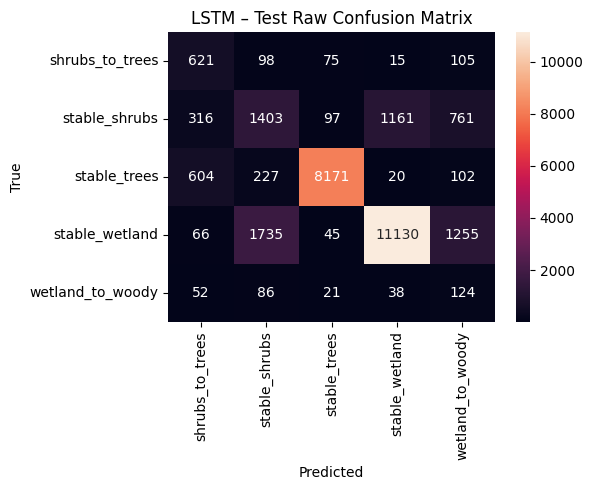

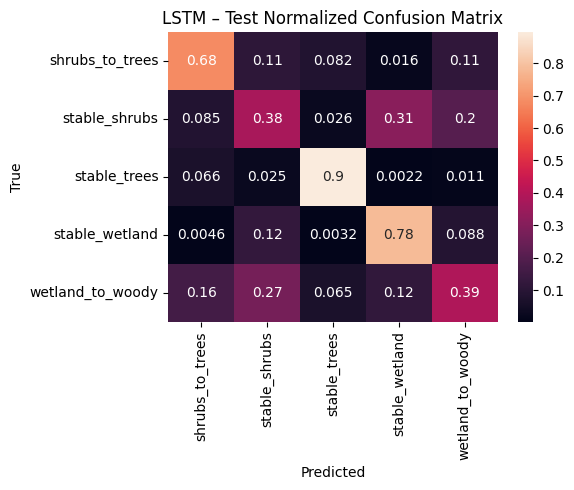

In [133]:
compute_and_plot_cms(y_true_lstm, y_pred_lstm, 'LSTM')


===== Sorted Confusion Pairs (raw counts): =====
stable_wetland       → stable_wetland       : 10369
stable_trees         → stable_trees         : 8124
stable_wetland       → stable_shrubs        : 2751
stable_shrubs        → stable_shrubs        : 1722
stable_shrubs        → stable_wetland       : 1002
stable_wetland       → wetland_to_woody     : 945
stable_trees         → shrubs_to_trees      : 710
shrubs_to_trees      → shrubs_to_trees      : 675
stable_shrubs        → wetland_to_woody     : 527
stable_shrubs        → shrubs_to_trees      : 342
stable_trees         → stable_shrubs        : 223
stable_shrubs        → stable_trees         : 145
wetland_to_woody     → wetland_to_woody     : 112
stable_wetland       → stable_trees         : 108
wetland_to_woody     → stable_shrubs        : 89
shrubs_to_trees      → stable_shrubs        : 81
shrubs_to_trees      → stable_trees         : 81
shrubs_to_trees      → wetland_to_woody     : 63
wetland_to_woody     → shrubs_to_trees      : 61

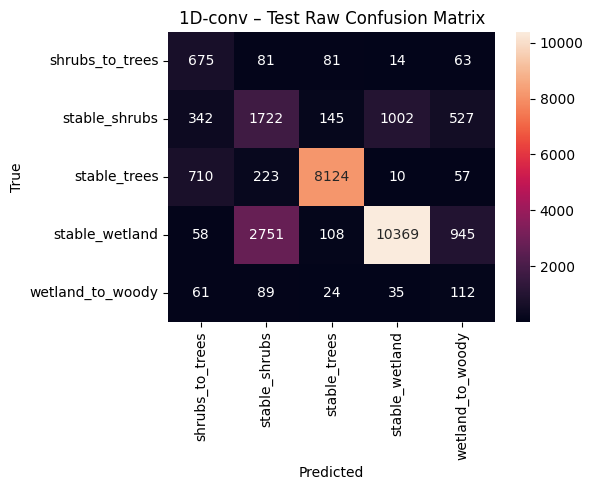

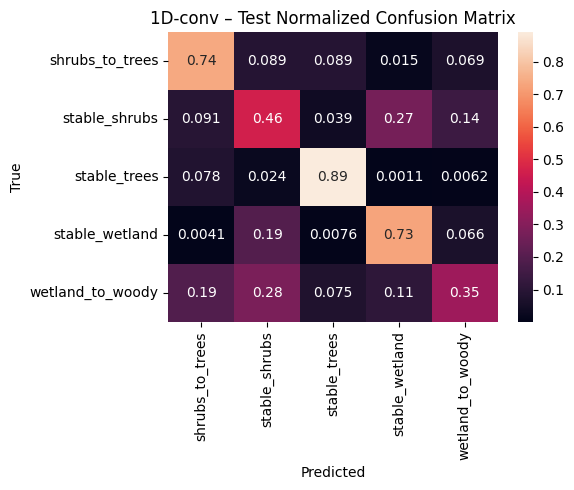

In [136]:
compute_and_plot_cms(y_true_conv, y_pred_conv, '1D-conv')

## Per-class distribution of indices and their time-series

Latest columns per index:
  NBR: NBR_2015_2016
  NDMI: NDMI_2015_2016
  NDVI: NDVI_2015_2016
  NIR: NIR_2015_2016
  SWIR1: SWIR1_2015_2016
  SWIR2: SWIR2_2015_2016


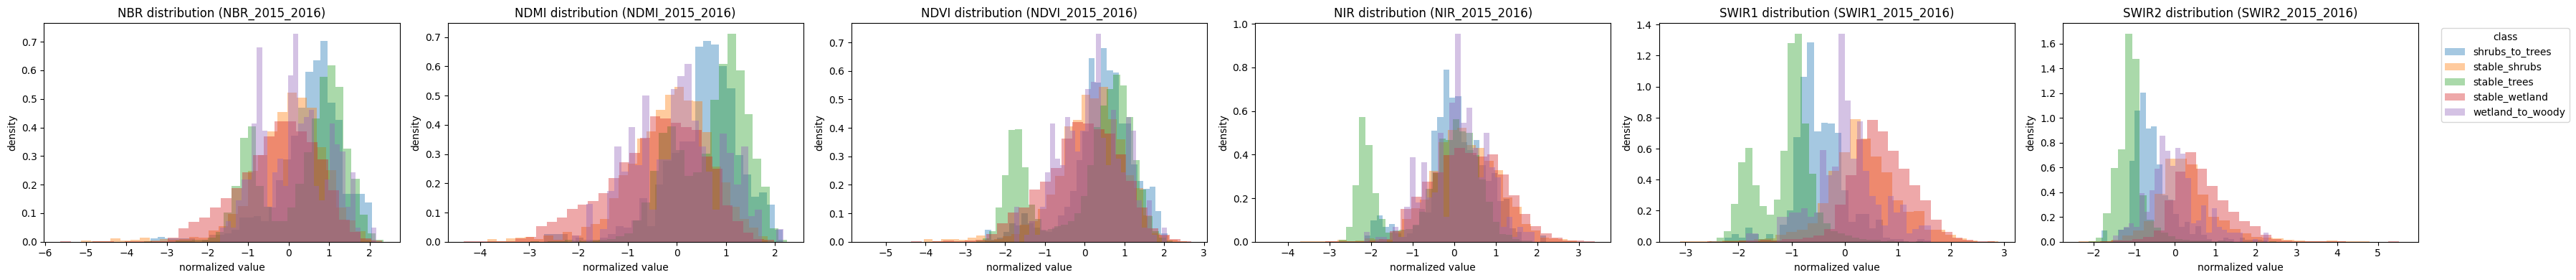

In [78]:
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------
# 1. Identify all index families and extract last time-step column
# ---------------------------------------------------

# extract index base name using regex (everything before the last "_<number>")
def get_index_base(col):
    m = col.split('_')
    return m[0] if m else None

# group columns by index type
index_groups = {}
for col in ts_cols:
    base = get_index_base(col)
    if base:
        index_groups.setdefault(base, []).append(col)

# sort each group and select the last (latest) time-step column
last_columns = {}
for base, cols in index_groups.items():
    cols_sorted = sorted(cols)     # NDVI_01, NDVI_02, ... NDVI_20
    last_columns[base] = cols_sorted[-1]

print("Latest columns per index:")
for k, v in last_columns.items():
    print(f"  {k}: {v}")

# ---------------------------------------------------
# 2. Prepare classes
# ---------------------------------------------------

classes = sorted(df_test_norm['class_str'].unique())

# ---------------------------------------------------
# 3. Make plots – one histogram per index family
# ---------------------------------------------------

num_indices = len(last_columns)
fig, axes = plt.subplots(1, num_indices, figsize=(6 * num_indices, 4), squeeze=False)
axes = axes[0]  # flatten

for ax, (index_name, col_name) in zip(axes, last_columns.items()):
    for cls in classes:
        subset = df_test_norm[df_test_norm['class_str'] == cls]
        ax.hist(subset[col_name], bins=30, alpha=0.4, density=True, label=cls)

    ax.set_title(f'{index_name} distribution ({col_name})')
    ax.set_xlabel('normalized value')
    ax.set_ylabel('density')

# Put legend on the last plot
axes[-1].legend(title="class", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Average time series per class

Detected index time-series groups:
  NBR: 10 time steps (NBR_1997_1998 → NBR_2015_2016)
  NDMI: 10 time steps (NDMI_1997_1998 → NDMI_2015_2016)
  NDVI: 10 time steps (NDVI_1997_1998 → NDVI_2015_2016)
  NIR: 10 time steps (NIR_1997_1998 → NIR_2015_2016)
  SWIR1: 10 time steps (SWIR1_1997_1998 → SWIR1_2015_2016)
  SWIR2: 10 time steps (SWIR2_1997_1998 → SWIR2_2015_2016)


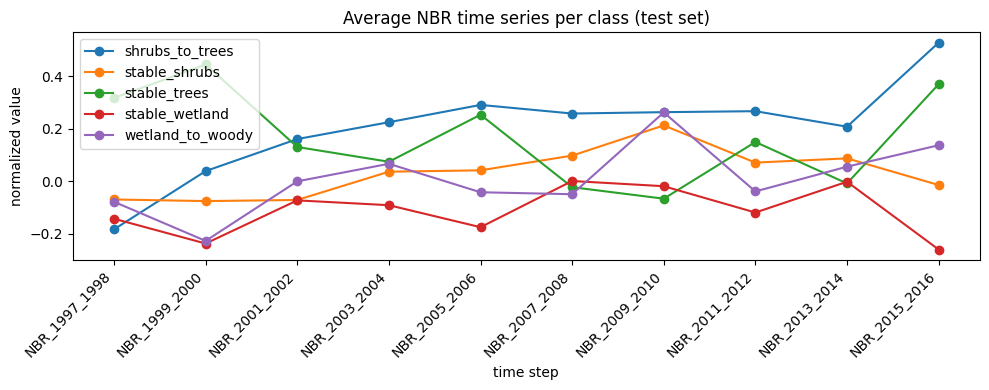

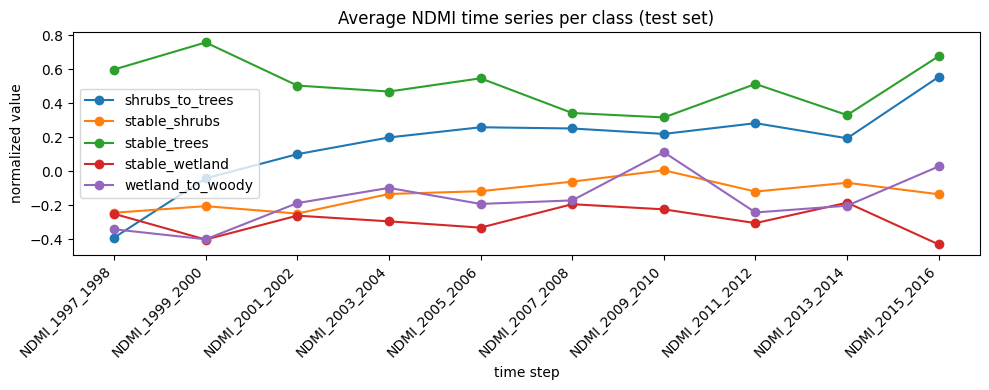

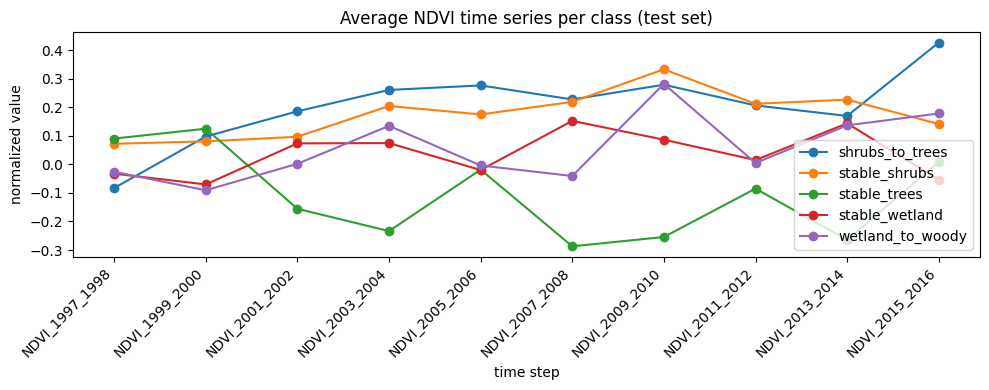

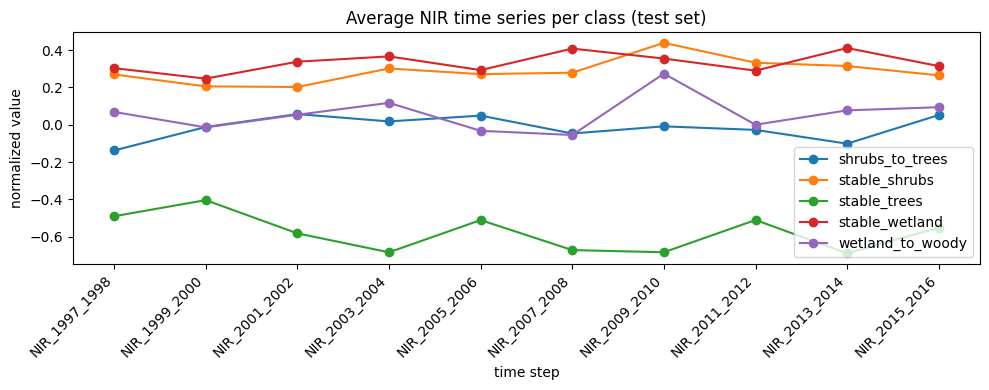

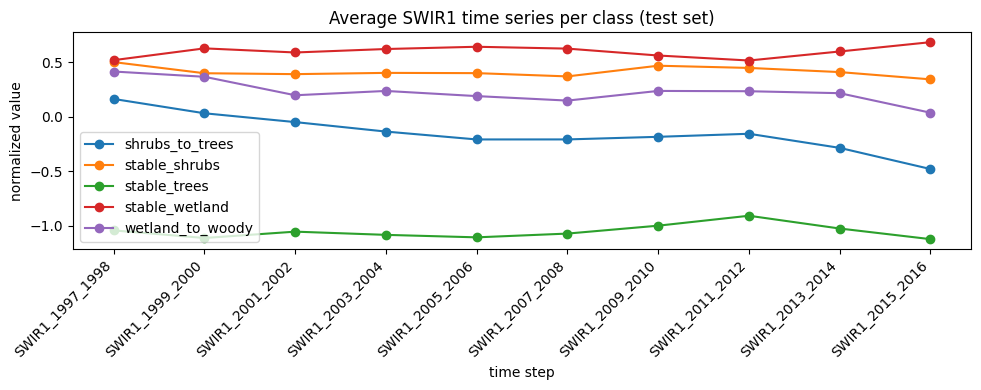

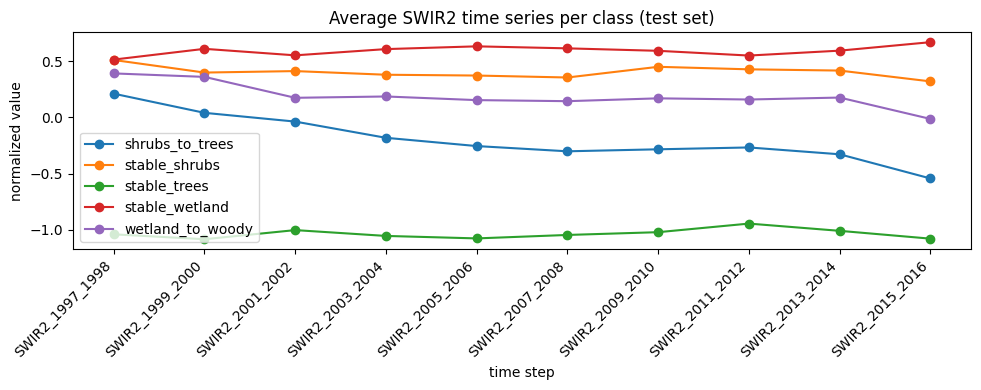

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import re

# ---------------------------------------------------
# 1. Identify index families and their time-step columns
# ---------------------------------------------------

# Group all ts_cols by base index name
index_groups = {}
for col in ts_cols:
    base = get_index_base(col)
    if base:
        index_groups.setdefault(base, []).append(col)

# Sort columns within each index (NDVI_01, NDVI_02, ..., NDVI_20)
for base in index_groups:
    index_groups[base] = sorted(index_groups[base])

print("Detected index time-series groups:")
for base, cols in index_groups.items():
    print(f"  {base}: {len(cols)} time steps ({cols[0]} → {cols[-1]})")

# ---------------------------------------------------
# 2. Prepare class list and helper plotting function
# ---------------------------------------------------

classes = sorted(df_test_norm['class_str'].unique())

def plot_mean_series(df, cols, title):
    T = len(cols)
    x = np.arange(T)

    plt.figure(figsize=(10, 4))
    for cls in classes:
        subset = df[df['class_str'] == cls]
        mean_series = subset[cols].mean(axis=0).values
        plt.plot(x, mean_series, marker='o', label=cls)

    plt.xticks(x, cols, rotation=45, ha='right')
    plt.xlabel('time step')
    plt.ylabel('normalized value')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------
# 3. Plot ALL index time series automatically
# ---------------------------------------------------

for base, cols in index_groups.items():
    plot_mean_series(
        df_test_norm,
        cols,
        f'Average {base} time series per class (test set)'
    )


### View the same plots, but separately for the classified and misclassified test pixels

In [81]:
import numpy as np

def get_all_preds_labels(model, loader, device):
    model.eval()
    all_y = []
    all_pred = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            all_y.extend(y.cpu().numpy())
            all_pred.extend(preds.cpu().numpy())
    return np.array(all_y), np.array(all_pred)

y_true, y_pred = get_all_preds_labels(lstm_model, test_loader, device)

# Assuming test_loader iterates df_test_norm in row order (shuffle=False),
# we can align them directly:
assert len(y_true) == len(df_test_norm)

mask_correct = (y_true == y_pred)
mask_wrong   = (y_true != y_pred)

print("Correct test examples:", mask_correct.sum())
print("Wrong test examples  :", mask_wrong.sum())

Correct test examples: 21109
Wrong test examples  : 7219


In [82]:
df_test_correct = df_test_norm[mask_correct].copy()
df_test_wrong   = df_test_norm[mask_wrong].copy()

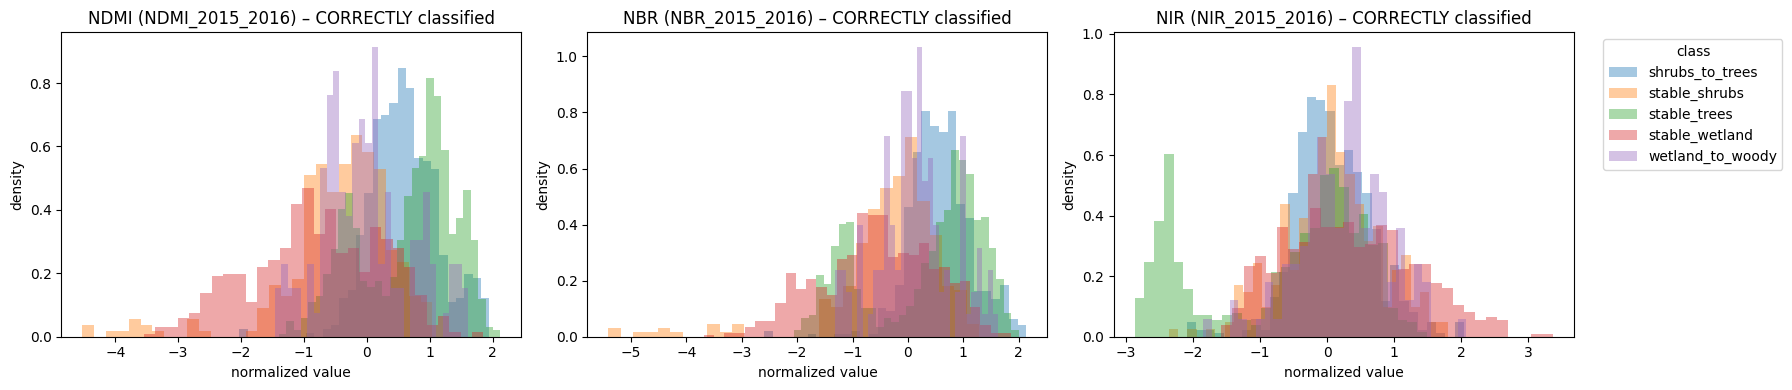

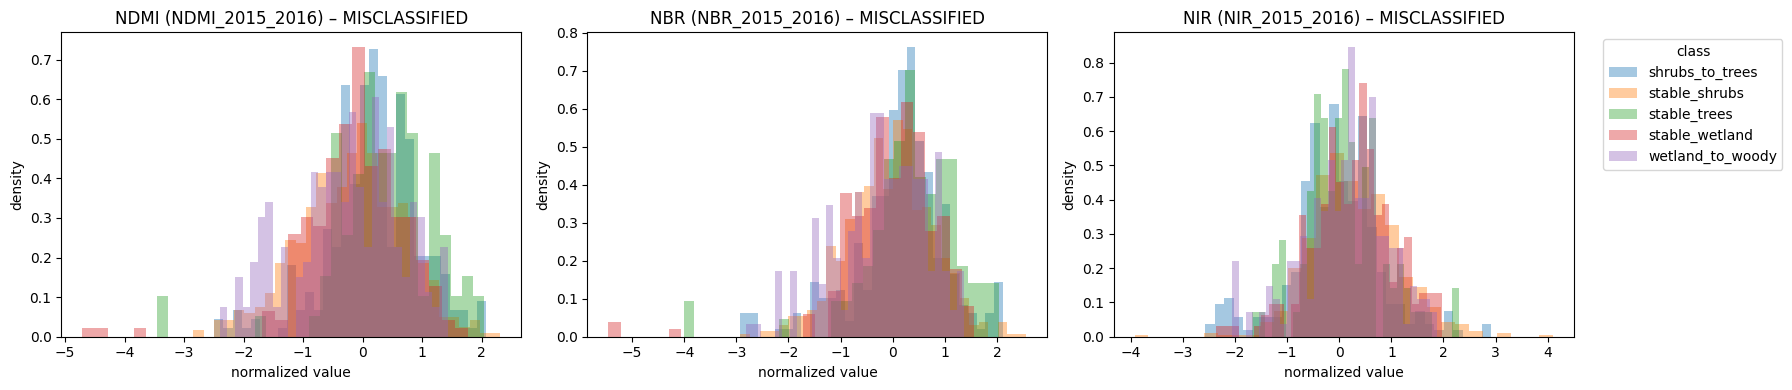

In [29]:
import matplotlib.pyplot as plt

ndmi_cols = sorted([c for c in ts_cols if c.startswith('NDMI_')])
nbr_cols  = sorted([c for c in ts_cols if c.startswith('NBR_')])
nir_cols  = sorted([c for c in ts_cols if c.startswith('NIR_')])

last_ndmi_col = ndmi_cols[-1]
last_nbr_col  = nbr_cols[-1]
last_nir_col  = nir_cols[-1]

def plot_distributions_by_class(df, title_suffix):
    classes = sorted(df['class_str'].unique())
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    for cls in classes:
        subset = df[df['class_str'] == cls]
        if len(subset) == 0:
            continue
        axes[0].hist(subset[last_ndmi_col], bins=30, alpha=0.4, label=cls, density=True)
        axes[1].hist(subset[last_nbr_col],  bins=30, alpha=0.4, label=cls, density=True)
        axes[2].hist(subset[last_nir_col],  bins=30, alpha=0.4, label=cls, density=True)

    axes[0].set_title(f'NDMI ({last_ndmi_col}) – ' + title_suffix)
    axes[1].set_title(f'NBR ({last_nbr_col}) – '  + title_suffix)
    axes[2].set_title(f'NIR ({last_nir_col}) – '  + title_suffix)

    for ax in axes:
        ax.set_xlabel('normalized value')
        ax.set_ylabel('density')

    axes[2].legend(title='class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_distributions_by_class(df_test_correct, "CORRECTLY classified")
plot_distributions_by_class(df_test_wrong,   "MISCLASSIFIED")

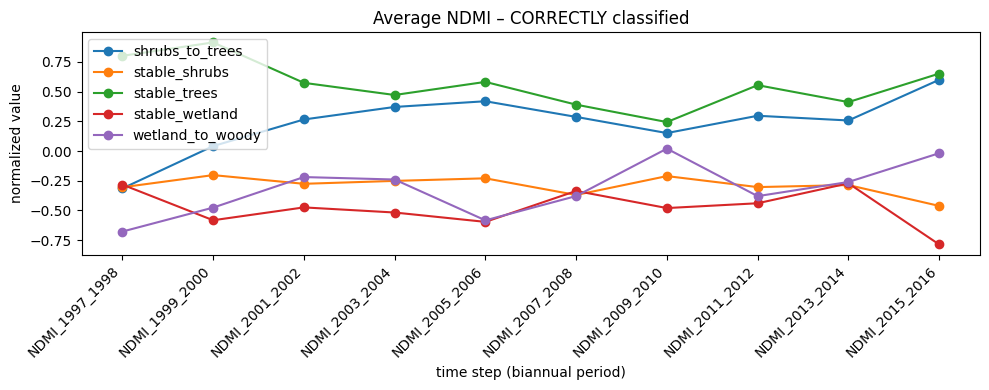

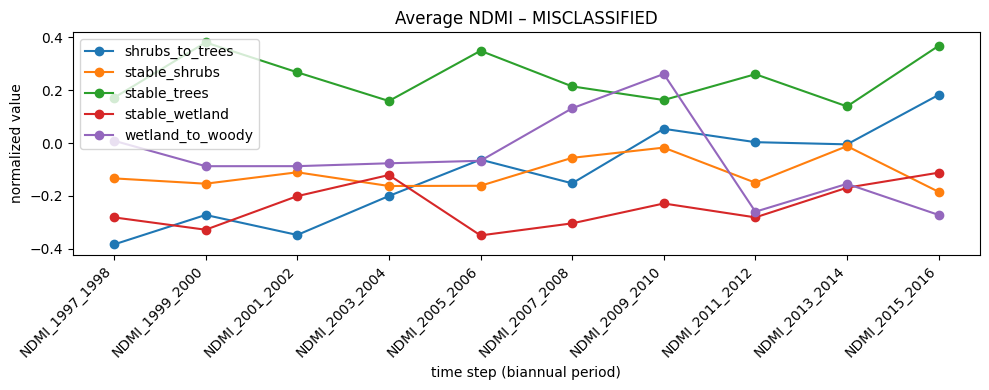

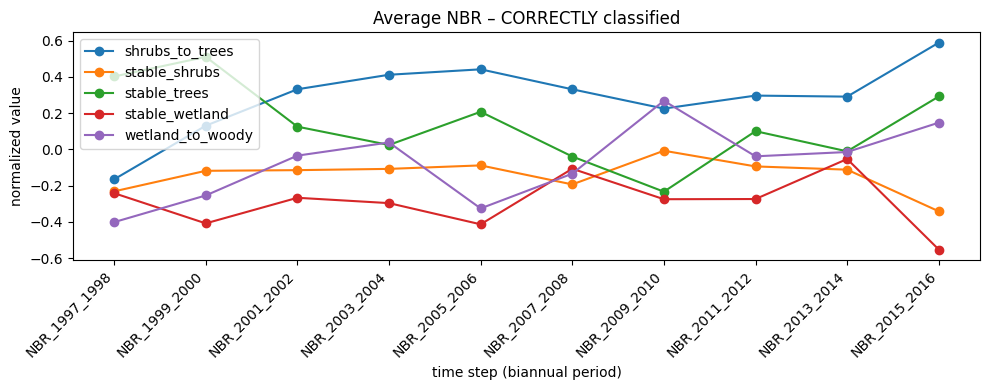

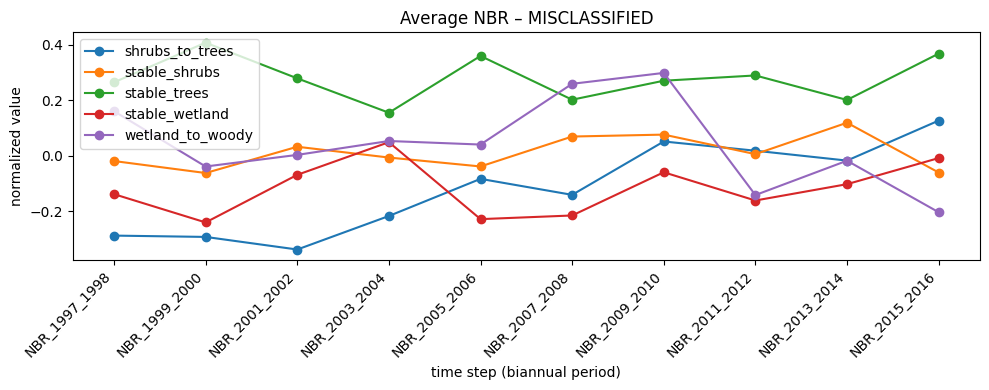

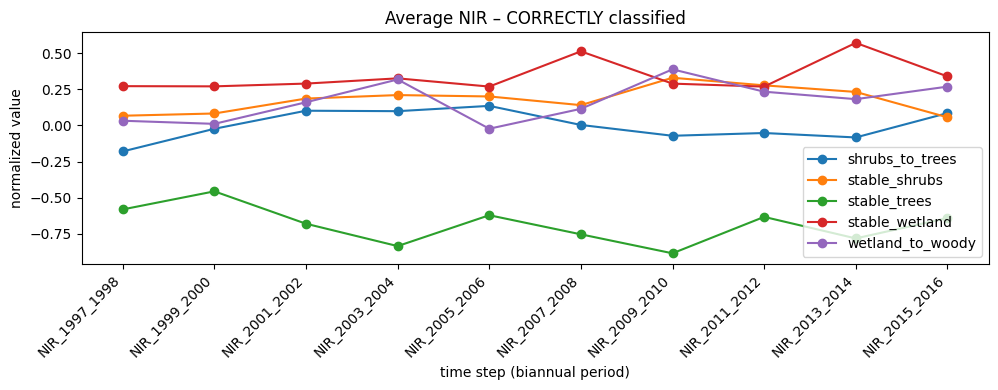

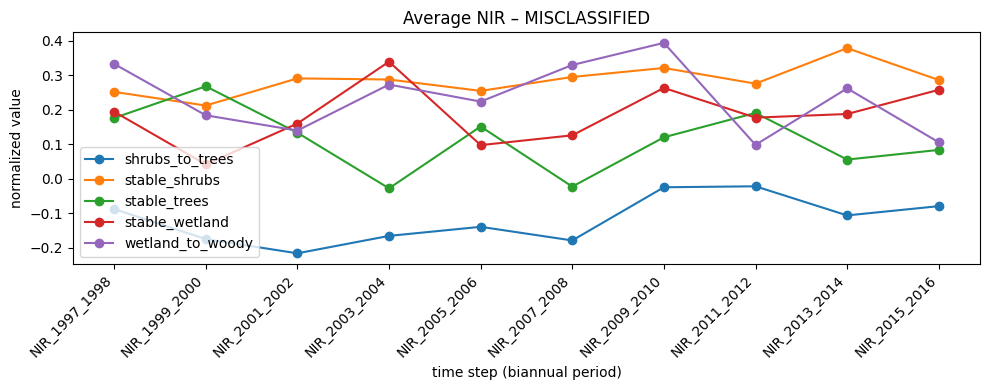

In [30]:
# NDMI
plot_mean_series(df_test_correct, ndmi_cols, "Average NDMI – CORRECTLY classified")
plot_mean_series(df_test_wrong,   ndmi_cols, "Average NDMI – MISCLASSIFIED")

# NBR
plot_mean_series(df_test_correct, nbr_cols, "Average NBR – CORRECTLY classified")
plot_mean_series(df_test_wrong,   nbr_cols, "Average NBR – MISCLASSIFIED")

# NIR
plot_mean_series(df_test_correct, nir_cols, "Average NIR – CORRECTLY classified")
plot_mean_series(df_test_wrong,   nir_cols, "Average NIR – MISCLASSIFIED")

## Model improvement

### Prune low-confidence samples in the training data

In [137]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Make a non-shuffling loader over the training dataset
clean_loader = DataLoader(train_ds, batch_size=512, shuffle=False)

lstm_model.eval()
all_label_probs = np.zeros(len(train_ds), dtype=np.float32)

offset = 0
with torch.no_grad():
    for X_batch, y_batch in clean_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = lstm_model(X_batch)              # [B, num_classes]
        probs = F.softmax(logits, dim=1)          # [B, num_classes]

        # Probability assigned to the *current* (possibly noisy) label
        p_label = probs[torch.arange(len(y_batch)), y_batch]  # [B]
        p_label = p_label.cpu().numpy()

        all_label_probs[offset:offset + len(y_batch)] = p_label
        offset += len(y_batch)

print("Computed label-consistent probabilities for", len(all_label_probs), "training samples.")

# Attach to df_train_norm (same order as train_ds)
df_train_norm = df_train_norm.copy()
df_train_norm["label_prob"] = all_label_probs

Computed label-consistent probabilities for 85488 training samples.


In [84]:
# How aggressive to prune (per class)
drop_quantile = 0.2   # drop lowest 20% of label_prob within each class

labels = df_train_norm["label_idx"].values
probs  = df_train_norm["label_prob"].values

keep_mask = np.ones(len(df_train_norm), dtype=bool)

for cls_idx, cls_name in enumerate(le.classes_):
    mask_cls = (labels == cls_idx)
    cls_probs = probs[mask_cls]
    if len(cls_probs) == 0:
        continue

    # Threshold: bottom `drop_quantile` within this class
    thr = np.quantile(cls_probs, drop_quantile)
    print(f"Class {cls_name}: dropping samples with label_prob < {thr:.3f} (q={drop_quantile})")

    # Keep only those above or equal to threshold
    keep_cls = cls_probs >= thr
    # Update global mask
    # mask_cls indices where keep_cls is False -> drop
    idx_cls = np.where(mask_cls)[0]
    keep_mask[idx_cls[~keep_cls]] = False

print("\nBefore cleaning:", len(df_train_norm))
print("After cleaning :", keep_mask.sum())

df_train_clean = df_train_norm[keep_mask].copy()

Class shrubs_to_trees: dropping samples with label_prob < 0.552 (q=0.2)
Class stable_shrubs: dropping samples with label_prob < 0.198 (q=0.2)
Class stable_trees: dropping samples with label_prob < 0.754 (q=0.2)
Class stable_wetland: dropping samples with label_prob < 0.398 (q=0.2)
Class wetland_to_woody: dropping samples with label_prob < 0.525 (q=0.2)

Before cleaning: 85488
After cleaning : 68389


In [85]:
print("\nPer-class counts BEFORE cleaning:")
print(df_train_norm["class_str"].value_counts())

print("\nPer-class counts AFTER cleaning:")
print(df_train_clean["class_str"].value_counts())


Per-class counts BEFORE cleaning:
class_str
stable_wetland      42793
stable_trees        27474
stable_shrubs       11437
shrubs_to_trees      2762
wetland_to_woody     1022
Name: count, dtype: int64

Per-class counts AFTER cleaning:
class_str
stable_wetland      34234
stable_trees        21979
stable_shrubs        9149
shrubs_to_trees      2209
wetland_to_woody      818
Name: count, dtype: int64


In [86]:
# Rebuild training dataset with cleaned data
train_ds_clean = PixelTimeSeriesDataset(df_train_clean, ts_cols, 'label_idx', C)

train_loader_clean = DataLoader(train_ds_clean, batch_size=batch_size, shuffle=True)

print("Clean train size:", len(train_ds_clean))

Clean train size: 68389


## Reinitialize the LSTM model and train it on clean data

In [105]:
class_counts_clean = df_train_clean['class_str'].value_counts().to_dict()
total_clean = len(df_train_clean)

class_weights_clean_dict = {
    cls: total_clean / (num_classes * class_counts_clean[cls])
    for cls in le.classes_
}

class_weights_clean = torch.tensor(
    [class_weights_clean_dict[cls] for cls in le.classes_],
    dtype=torch.float32
).to(device)

train_loader_clean, val_loader_clean, test_loader_clean = define_loaders(train_ds_clean, df_val_norm, df_test_norm)


len(train_ds): 85488
len(val_ds): 28511
len(test_ds): 28328


In [106]:
conv_model_clean = define_and_train_conv1d_model(train_loader_clean, val_loader_clean, test_loader_clean, class_weights_clean)

Epoch 01: train_loss=1.2589, train_acc=0.632, val_loss=1.1145, val_acc=0.688
Epoch 02: train_loss=1.0722, train_acc=0.667, val_loss=1.0566, val_acc=0.705
Epoch 03: train_loss=1.0118, train_acc=0.684, val_loss=1.0068, val_acc=0.678
Epoch 04: train_loss=0.9718, train_acc=0.694, val_loss=0.9787, val_acc=0.691
Epoch 05: train_loss=0.9381, train_acc=0.701, val_loss=0.9570, val_acc=0.671
Epoch 06: train_loss=0.9149, train_acc=0.703, val_loss=0.9571, val_acc=0.695
Epoch 07: train_loss=0.8937, train_acc=0.707, val_loss=0.9421, val_acc=0.722
Epoch 08: train_loss=0.8817, train_acc=0.710, val_loss=0.9450, val_acc=0.685
Epoch 09: train_loss=0.8640, train_acc=0.715, val_loss=0.9331, val_acc=0.700
Epoch 10: train_loss=0.8548, train_acc=0.715, val_loss=0.9255, val_acc=0.738
Epoch 11: train_loss=0.8405, train_acc=0.719, val_loss=0.9294, val_acc=0.708
Epoch 12: train_loss=0.8300, train_acc=0.721, val_loss=0.9308, val_acc=0.714
Epoch 13: train_loss=0.8187, train_acc=0.725, val_loss=0.9146, val_acc=0.732

In [107]:
lstm_model_clean = define_and_train_lstm_model(train_loader_clean, val_loader_clean, test_loader_clean, class_weights_clean)

Epoch 01: train_loss=1.1659, train_acc=0.681, val_loss=1.0914, val_acc=0.638
Epoch 02: train_loss=1.0393, train_acc=0.674, val_loss=1.0145, val_acc=0.690
Epoch 03: train_loss=0.9600, train_acc=0.685, val_loss=0.9783, val_acc=0.714
Epoch 04: train_loss=0.8948, train_acc=0.701, val_loss=0.9680, val_acc=0.714
Epoch 05: train_loss=0.8518, train_acc=0.711, val_loss=0.9483, val_acc=0.734
Epoch 06: train_loss=0.8223, train_acc=0.721, val_loss=0.9503, val_acc=0.690
Epoch 07: train_loss=0.8001, train_acc=0.725, val_loss=0.9404, val_acc=0.705
Epoch 08: train_loss=0.7775, train_acc=0.732, val_loss=0.9705, val_acc=0.762
Epoch 09: train_loss=0.7586, train_acc=0.736, val_loss=0.9455, val_acc=0.727
Epoch 10: train_loss=0.7377, train_acc=0.738, val_loss=0.9575, val_acc=0.713
Epoch 11: train_loss=0.7214, train_acc=0.743, val_loss=0.9786, val_acc=0.746
Epoch 12: train_loss=0.7016, train_acc=0.747, val_loss=0.9486, val_acc=0.703
Epoch 13: train_loss=0.6863, train_acc=0.750, val_loss=0.9641, val_acc=0.729

In [108]:
y_true_clean_lstm, y_pred_clean_lstm = get_all_preds_labels(lstm_model_clean, test_loader_clean, device)

print("Classification report (LSTM on TEST):")
print(classification_report(y_true_clean_lstm, y_pred_clean_lstm, target_names=le.classes_))

Classification report (LSTM on TEST):
                  precision    recall  f1-score   support

 shrubs_to_trees       0.32      0.72      0.44       914
   stable_shrubs       0.37      0.49      0.42      3738
    stable_trees       0.98      0.86      0.91      9124
  stable_wetland       0.90      0.76      0.82     14231
wetland_to_woody       0.06      0.28      0.10       321

        accuracy                           0.75     28328
       macro avg       0.53      0.62      0.54     28328
    weighted avg       0.83      0.75      0.78     28328



In [110]:
y_true_clean_1dconv, y_pred_clean_1dconv = get_all_preds_labels(conv_model_clean, test_loader_clean, device)

print("Classification report (1D-Conv on TEST):")
print(classification_report(y_true_clean_1dconv, y_pred_clean_1dconv, target_names=le.classes_))

Classification report (1D-Conv on TEST):
                  precision    recall  f1-score   support

 shrubs_to_trees       0.34      0.76      0.47       914
   stable_shrubs       0.34      0.41      0.38      3738
    stable_trees       0.97      0.87      0.92      9124
  stable_wetland       0.91      0.71      0.80     14231
wetland_to_woody       0.05      0.42      0.10       321

        accuracy                           0.72     28328
       macro avg       0.52      0.63      0.53     28328
    weighted avg       0.83      0.72      0.76     28328




===== Sorted Confusion Pairs (raw counts): =====
stable_wetland       → stable_wetland       : 10786
stable_trees         → stable_trees         : 7804
stable_wetland       → stable_shrubs        : 2500
stable_shrubs        → stable_shrubs        : 1815
stable_shrubs        → stable_wetland       : 1058
stable_trees         → shrubs_to_trees      : 900
stable_wetland       → wetland_to_woody     : 798
shrubs_to_trees      → shrubs_to_trees      : 660
stable_shrubs        → wetland_to_woody     : 431
stable_shrubs        → shrubs_to_trees      : 345
stable_trees         → stable_shrubs        : 312
shrubs_to_trees      → stable_shrubs        : 125
stable_wetland       → shrubs_to_trees      : 105
wetland_to_woody     → stable_shrubs        : 103
wetland_to_woody     → wetland_to_woody     : 91
stable_shrubs        → stable_trees         : 89
stable_trees         → wetland_to_woody     : 76
wetland_to_woody     → shrubs_to_trees      : 62
shrubs_to_trees      → wetland_to_woody     : 61

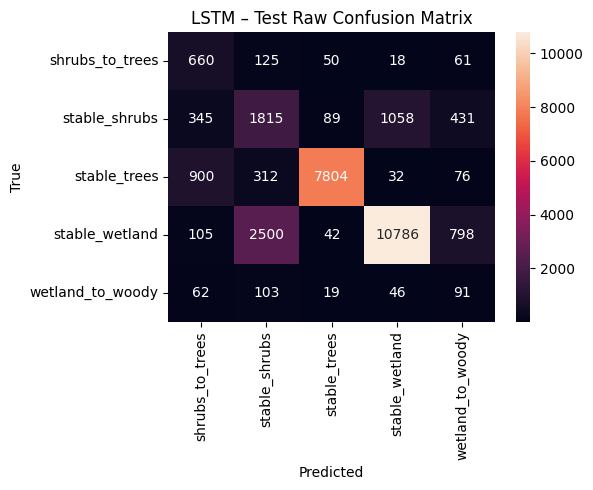

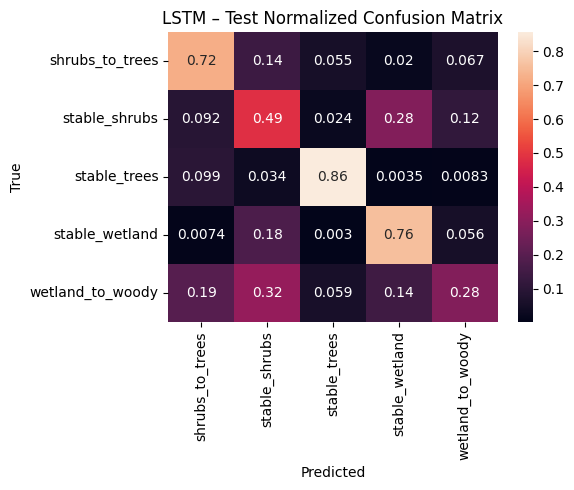

In [139]:
compute_and_plot_cms(y_true_lstm_clean, y_pred_lstm_clean, 'LSTM')


===== Sorted Confusion Pairs (raw counts): =====
stable_wetland       → stable_wetland       : 10072
stable_trees         → stable_trees         : 7963
stable_wetland       → stable_shrubs        : 2626
stable_shrubs        → stable_shrubs        : 1548
stable_wetland       → wetland_to_woody     : 1400
stable_shrubs        → stable_wetland       : 905
stable_trees         → shrubs_to_trees      : 871
stable_shrubs        → wetland_to_woody     : 777
shrubs_to_trees      → shrubs_to_trees      : 697
stable_shrubs        → shrubs_to_trees      : 390
stable_trees         → stable_shrubs        : 172
wetland_to_woody     → wetland_to_woody     : 134
stable_shrubs        → stable_trees         : 118
stable_trees         → wetland_to_woody     : 105
shrubs_to_trees      → wetland_to_woody     : 79
stable_wetland       → stable_trees         : 76
wetland_to_woody     → stable_shrubs        : 76
shrubs_to_trees      → stable_shrubs        : 66
shrubs_to_trees      → stable_trees         : 58

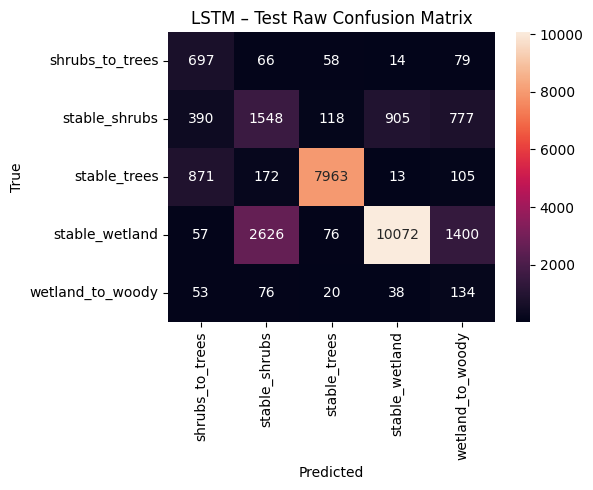

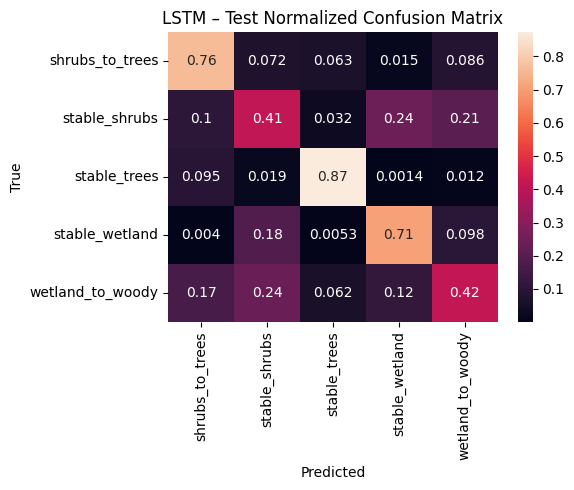

In [140]:
compute_and_plot_cms(y_true_conv_clean, y_pred_conv_clean, 'LSTM')